<a href="https://colab.research.google.com/github/KauaHenSilva/python_predict_stock_prices/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recuperação por download

In [104]:
# @markdown #### Caso escolheu o tipo de recuperação drive/ambos e não tenha os arquivos, faça um atalho desse drive:
link_do_drive = "https://drive.google.com/drive/folders/1uwHnZRnVPt6ha5s_cyZSAoCP7ATWBEwN?usp=drive_link" #@param {type:"string"}
path_atalho_drive = "/content/drive/MyDrive/Projetos Do GitHub/python_predict_stock_prices" #@param {type:"string"}
path_download = "python_predict_stock_prices" #@param {type:"string"}

In [105]:
import os
import zipfile

if os.path.exists('python_download_file_drive'):
  !cd python_download_file_drive && git pull
else:
  !git clone https://github.com/KauaHenSilva/python_download_file_drive
%pip install --upgrade --quiet -r python_download_file_drive/requirements.txt


Already up to date.


In [106]:
try:
    from google.colab import drive
    from google.colab import auth
    from googleapiclient.discovery import build
    auth.authenticate_user()

    !python "python_download_file_drive/main.py" {link_do_drive} {path_download} # ALERTA: Caso o drive bote limite de download comente essa linha

    drive.mount('/content/drive')
    if not os.path.exists(path_atalho_drive):
      print("[INFO] Atalho no drive não encontrado.")

except:

    if os.path.exists(f"{path_download}.zip"):
      print(f"Descompactando {path_download}.zip")
      !rm -rf {path_download}
      with zipfile.ZipFile(f"{path_download}.zip", 'r') as zip_ref:
        zip_ref.extractall(f"{path_download}_temp")
        !mv {path_download}_temp/* {path_download}
        !rm -rf {path_download}_temp
        !rm -rf {path_download}.zip

    if not os.path.exists(path_download):
      raise Exception(f"Você não está nos altenticado nos servidores do google colab. Para prosseguir, faça o download dos arquivos que estão presente no drive e tente novamente. O link do drive {link_do_drive}. A pasta deve está dentro de /content/")


In [107]:
def get_referencia_valida(path, file_init):
    path_download = os.path.join(f"/content/{file_init}", path)
    path_drive = os.path.join(path_atalho_drive, path)

    bool_download = os.path.exists(path_download)
    bool_drive = os.path.exists(path_drive)

    if not bool_download and not bool_drive:
        raise Exception(f"Arquivo não encontrado em nenhum dos caminhos (Download ou Drive). Caminhos: {path_download}, {path_drive}")

    if not bool_drive and bool_download:
        print("[INFO] Arquivo encontrado no download, mas não no drive.")
        return path_download

    if bool_drive and not bool_download:
        print("[INFO] Arquivo encontrado no drive, mas não no download.")
        return path_drive

    return path_download


# Bolsa de valores

In [108]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

In [109]:
np.__version__, pd.__version__, matplotlib.__version__, tf.__version__, sklearn.__version__

('1.26.4', '2.2.2', '3.8.0', '2.16.1', '1.6.0')

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import  MinMaxScaler
import matplotlib.pyplot as plt

In [111]:
path_database_test = get_referencia_valida("petr4_teste.csv", path_download)
path_database_treinamento = get_referencia_valida("petr4_treinamento.csv", path_download)

[INFO] Arquivo encontrado no download, mas não no drive.
[INFO] Arquivo encontrado no download, mas não no drive.


In [112]:
database_treinamento = pd.read_csv(path_database_treinamento)
database_teste = pd.read_csv(path_database_test)

In [113]:
database_treinamento.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [114]:
database_teste.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [115]:
database_teste.isnull().sum(), database_treinamento.isnull().sum()

(Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Date         0
 Open         3
 High         3
 Low          3
 Close        3
 Adj Close    3
 Volume       3
 dtype: int64)

In [116]:
database_treinamento = database_treinamento.dropna()
database_teste.isnull().sum(), database_treinamento.isnull().sum()

(Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64)

In [117]:
database_treinamento.shape, database_teste.shape

((1242, 7), (22, 7))

In [118]:
base_treinamento = database_treinamento.iloc[:, 1:2].values
base_teste = database_teste.iloc[:, 1:2].values

In [119]:
base_treinamento, base_teste

(array([[19.99    ],
        [19.809999],
        [20.33    ],
        ...,
        [15.99    ],
        [16.1     ],
        [16.1     ]]),
 array([[16.190001],
        [16.49    ],
        [16.780001],
        [16.700001],
        [16.74    ],
        [17.030001],
        [16.92    ],
        [16.879999],
        [17.040001],
        [17.32    ],
        [17.35    ],
        [17.92    ],
        [18.35    ],
        [18.309999],
        [18.26    ],
        [18.4     ],
        [18.42    ],
        [19.34    ],
        [19.620001],
        [19.67    ],
        [19.77    ],
        [19.74    ]]))

In [120]:
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_teste_normalizada = normalizador.transform(base_teste)

In [121]:
base_treinamento_normalizada, base_teste_normalizada

(array([[0.76501938],
        [0.7562984 ],
        [0.78149225],
        ...,
        [0.57122093],
        [0.57655039],
        [0.57655039]]),
 array([[0.5809109 ],
        [0.59544574],
        [0.60949617],
        [0.6056202 ],
        [0.60755814],
        [0.62160858],
        [0.61627907],
        [0.61434104],
        [0.62209307],
        [0.63565891],
        [0.6371124 ],
        [0.66472868],
        [0.68556202],
        [0.68362398],
        [0.68120155],
        [0.6879845 ],
        [0.68895349],
        [0.73352713],
        [0.74709307],
        [0.7495155 ],
        [0.75436047],
        [0.75290698]]))

In [122]:
base_treinamento_normalizada.shape, base_teste_normalizada.shape

((1242, 1), (22, 1))

In [123]:
x = []
y = []
for i in range(90, 1242):
    x.append(base_treinamento_normalizada[i-90:i, 0])
    y.append(base_treinamento_normalizada[i, 0])

x = np.array(x)
y = np.array(y)
x.shape, y.shape

((1152, 90), (1152,))

In [124]:
x[0], y[0]

(array([0.76501938, 0.7562984 , 0.78149225, 0.78875969, 0.77083338,
        0.74806197, 0.75436047, 0.75823643, 0.76598837, 0.76598837,
        0.76017437, 0.75872098, 0.75581391, 0.74467054, 0.7374031 ,
        0.7374031 , 0.73498067, 0.75242248, 0.73401163, 0.71656977,
        0.68120155, 0.67538755, 0.67635659, 0.63372098, 0.66521318,
        0.65649225, 0.64680228, 0.66618222, 0.65843028, 0.64970935,
        0.65116274, 0.66424419, 0.67344961, 0.64292631, 0.64486434,
        0.62257747, 0.60949617, 0.60998067, 0.60852713, 0.59593023,
        0.61143411, 0.60222863, 0.64922481, 0.68362398, 0.70687989,
        0.68265509, 0.70978682, 0.70784879, 0.71608527, 0.73643411,
        0.7122093 , 0.7122093 , 0.7194767 , 0.70348832, 0.69525189,
        0.70397287, 0.70397287, 0.69767442, 0.68168605, 0.68168605,
        0.65310078, 0.66618222, 0.64825581, 0.66182175, 0.64341085,
        0.67877902, 0.69137592, 0.66569772, 0.65406982, 0.64292631,
        0.64147292, 0.63565891, 0.67587209, 0.68

In [125]:
net = Sequential()

net.add(LSTM(units=100, return_sequences=True, input_shape=(x.shape[1], 1)))
net.add(Dropout(0.3))

net.add(LSTM(units=50, return_sequences=True))
net.add(Dropout(0.3))

net.add(LSTM(units=50, return_sequences=True))
net.add(Dropout(0.3))

net.add(LSTM(units=50))
net.add(Dropout(0.3))

net.add(Dense(units=1, activation='linear'))

net.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 90, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 90, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,451 (435.36 KB)

 Trainable params: 111,451 (435.36 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
net.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [127]:
net.fit(x, y, epochs=100, batch_size=32)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0608 - mean_absolute_error: 0.1806
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0137 - mean_absolute_error: 0.0927  
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0109 - mean_absolute_error: 0.0835
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0128 - mean_absolute_error: 0.0868
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0095 - mean_absolute_error: 0.0747
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0081 - mean_absolute_error: 0.0692 
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - mean_absolute_error: 0.0830
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0079 - mean_absolute_error: 0.0701
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0096 - mean_absolute_error: 0.0747
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0083 - mean_absolute_error: 0.0700
Epoch 11/100
36/36 ━━━━━━━

In [128]:
base_completa = pd.concat((database_treinamento.iloc[:, 1:2], database_teste.iloc[:, 1:2]), axis=0)
base_completa.shape

(1264, 1)

In [129]:
entradas = base_completa[len(base_completa) - len(database_teste) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas.shape

(112, 1)

In [130]:
entradas_normalizada = normalizador.transform(entradas)
entradas_normalizada

array([[0.47141473],
       [0.46317829],
       [0.46463178],
       [0.45203488],
       [0.46753876],
       [0.47286822],
       [0.50242248],
       [0.50629845],
       [0.52422481],
       [0.52810078],
       [0.51744186],
       [0.52228682],
       [0.52034884],
       [0.5247093 ],
       [0.52664729],
       [0.52422481],
       [0.52810078],
       [0.53536822],
       [0.56443798],
       [0.55232558],
       [0.56153101],
       [0.56492248],
       [0.55717054],
       [0.54118217],
       [0.54748062],
       [0.53246124],
       [0.55232558],
       [0.56686047],
       [0.56589147],
       [0.55523256],
       [0.55281008],
       [0.57800383],
       [0.57994186],
       [0.5755814 ],
       [0.58284884],
       [0.57945736],
       [0.57848832],
       [0.58236429],
       [0.57170543],
       [0.5809109 ],
       [0.58575586],
       [0.58575586],
       [0.59738377],
       [0.60949617],
       [0.60901163],
       [0.6187015 ],
       [0.61531008],
       [0.619

In [131]:
x_test = []
for i in range(90, 112):
    x_test.append(entradas_normalizada[i-90:i, 0])

x_test = np.array(x_test)
x_test.shape

(22, 90)

In [132]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(22, 90, 1)

In [133]:
previsoes = net.predict(x_test)
previsoes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


array([[0.56875443],
       [0.57247686],
       [0.5765122 ],
       [0.58273804],
       [0.58965546],
       [0.5955558 ],
       [0.6011826 ],
       [0.60560423],
       [0.60791993],
       [0.60920984],
       [0.6118771 ],
       [0.61617863],
       [0.6244345 ],
       [0.63777804],
       [0.6526952 ],
       [0.6647881 ],
       [0.6726794 ],
       [0.6765566 ],
       [0.68304455],
       [0.69468856],
       [0.7089211 ],
       [0.7222614 ]], dtype=float32)

In [134]:
previsoes = normalizador.inverse_transform(previsoes)
previsoes

array([[15.939091],
       [16.015923],
       [16.099213],
       [16.227713],
       [16.37049 ],
       [16.492271],
       [16.608408],
       [16.69967 ],
       [16.747467],
       [16.77409 ],
       [16.829142],
       [16.917927],
       [17.088327],
       [17.363739],
       [17.671629],
       [17.921227],
       [18.084103],
       [18.164127],
       [18.298038],
       [18.538372],
       [18.83213 ],
       [19.107475]], dtype=float32)

In [135]:
base_teste

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [136]:
previsoes.mean(), base_teste.mean()

(17.217752, 17.87454563636364)

In [137]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(base_teste, previsoes), mean_squared_error(base_teste, previsoes)

(0.6567923994196113, 0.5479345140815277)

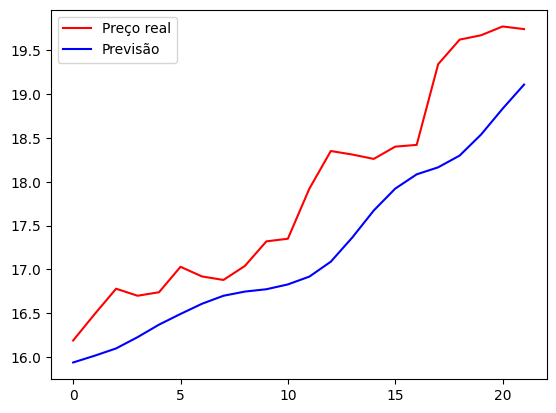

In [139]:
plt.plot(base_teste, color='red', label='Preço real');
plt.plot(previsoes, color='blue', label='Previsão');
plt.legend();